## Data Loading and Pre-processing

In [1]:
# import all the libraries
import json
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import re

import time
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
color = sns.color_palette()
sns.set_style("dark")

ModuleNotFoundError: No module named 'textblob'

In [2]:
# Load data from reviews json file into dataframe
data = {'business_id': [],'date': [], 'stars': [], 'text': []}
with open('./yelp_dataset/review.json') as f:
    for line in tqdm(f):
        review = json.loads(line)
        data['business_id'].append(review['business_id'])
        data['date'].append(review['date'])
        data['stars'].append(review['stars'])
        data['text'].append(review['text'])  
reviews_df = pd.DataFrame(data)

6685900it [01:08, 98016.47it/s] 


In [3]:
# Load data from business json file into dataframe
data2 = {'business_id': [], 'name': [], 'city': [], 'categories': []}
with open('./yelp_dataset/business.json') as f:
    for line in tqdm(f):
        business = json.loads(line)
        data2['business_id'].append(business['business_id'])
        data2['name'].append(business['name'])
        data2['city'].append(business['city'])
        data2['categories'].append(business['categories'])
business_df = pd.DataFrame(data2)

192609it [00:04, 45379.78it/s]


In [4]:
# View first 3 records in reviews data frame
reviews_df.head(3)

,business_id,date,stars,text
0,ujmEBvifdJM6h6RLv4wQIg,2013-05-07 04:34:36,1.0,Total bill for this horrible service? Over $8G...
1,NZnhc2sEQy3RmzKTZnqtwQ,2017-01-14 21:30:33,5.0,I *adore* Travis at the Hard Rock's new Kelly ...
2,WTqjgwHlXbSFevF32_DJVw,2016-11-09 20:09:03,5.0,I have to say that this office really has it t...


In [5]:
# Shape of reviews data frame - rows and columns
print(reviews_df.shape)

(6685900, 4)


In [6]:
# View first 3 records in business data frame
business_df.head(3)

,business_id,name,city,categories
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,"Golf, Active Life"
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,"Specialty Food, Restaurants, Dim Sum, Imported..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,"Sushi Bars, Restaurants, Japanese"


In [7]:
# Shape of business data frame - rows and columns
print(business_df.shape)

(192609, 4)


In [8]:
# Merge both the data frames on business id column
df = pd.merge(left=reviews_df,right=business_df, left_on='business_id', right_on='business_id')
df.shape

(6685900, 7)

In [9]:
df.head(3)

,business_id,date,stars,text,name,city,categories
0,ujmEBvifdJM6h6RLv4wQIg,2013-05-07 04:34:36,1.0,Total bill for this horrible service? Over $8G...,MountainView Hospital,Las Vegas,"Fitness & Instruction, Doctors, Health & Medic..."
1,ujmEBvifdJM6h6RLv4wQIg,2017-02-09 06:45:18,4.0,My family has used this ER four times in the p...,MountainView Hospital,Las Vegas,"Fitness & Instruction, Doctors, Health & Medic..."
2,ujmEBvifdJM6h6RLv4wQIg,2018-08-14 05:25:33,1.0,I have never been more disappointed by the car...,MountainView Hospital,Las Vegas,"Fitness & Instruction, Doctors, Health & Medic..."


In [10]:
# Check the data frame column data types
df.dtypes

business_id     object
date            object
stars          float64
text            object
name            object
city            object
categories      object
dtype: object

In [11]:
# Update the data types of all the columns
df['business_id'] = df['business_id'].astype(str)
df['date'] = pd.to_datetime(df['date'])
df['stars'] = df['stars'].astype('category')
df['text'] = df['text'].astype(str)
df['name'] = df['name'].astype(str)
df['city'] = df['city'].astype(str)
df['categories'] = df['categories'].astype(str)

# Verify the data types
df.dtypes

business_id            object
date           datetime64[ns]
stars                category
text                   object
name                   object
city                   object
categories             object
dtype: object

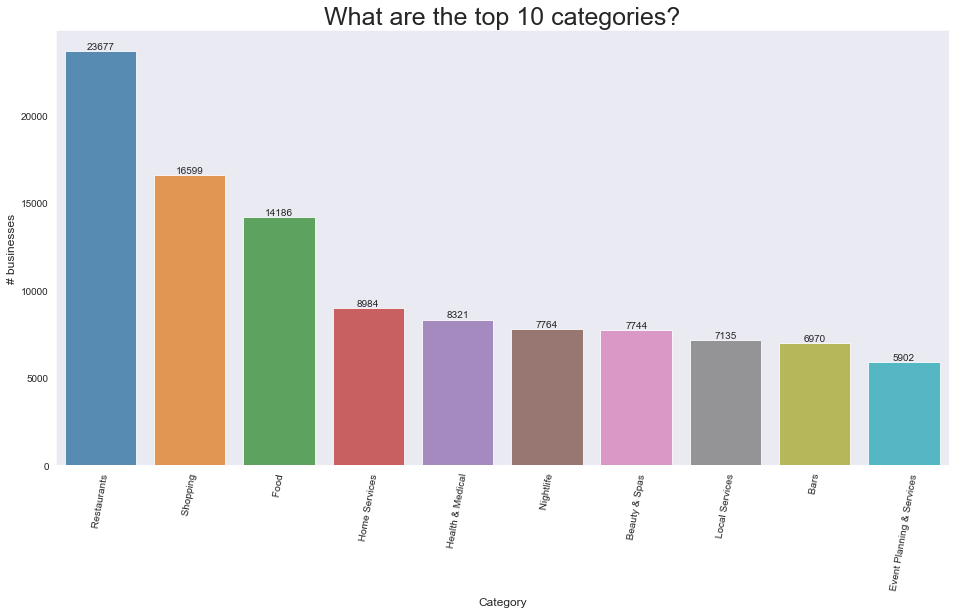

In [12]:
# What are the popular business categories?
business_df['categories'] = business_df['categories'].astype(str)
business_cats = ' '.join(business_df['categories'])
cats = pd.DataFrame(business_cats.split(','),columns=['category'])
x = cats.category.value_counts()

#prep for chart
x=x.sort_values(ascending=False)
x=x.iloc[0:10]

#chart
plt.figure(figsize=(16,8))
ax = sns.barplot(x.index, x.values, alpha=0.8)#,color=color[5])
plt.title("What are the top 10 categories?",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [13]:
# Filter records - keep only restaurant category records
df['is_restaurant'] = [bool(re.search("Restaurants", category)) for category in df.categories]
df = df[df.is_restaurant == True]
df.shape

(4201684, 8)

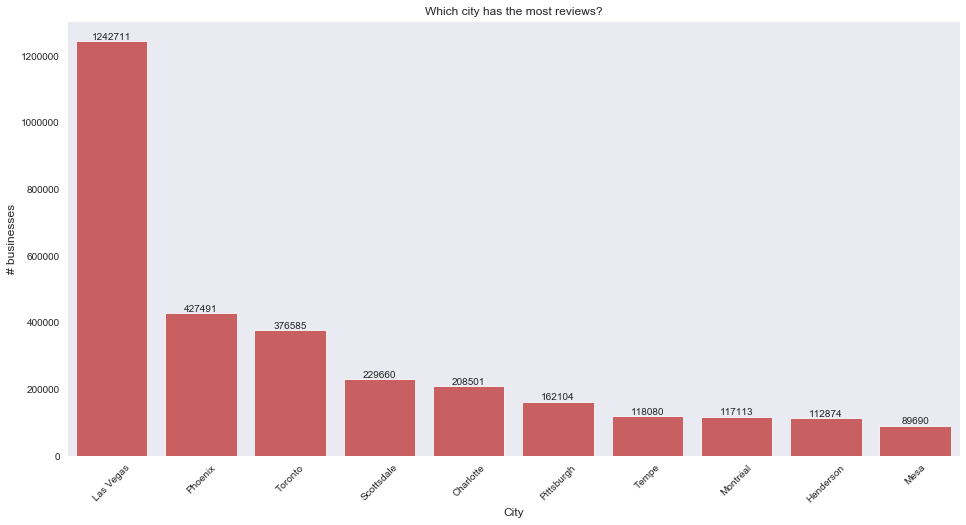

In [14]:
# Get the distribution of the ratings
x=df['city'].value_counts()
x=x.sort_values(ascending=False)
x=x.iloc[0:10]
plt.figure(figsize=(16,8))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[3])
plt.title("Which city has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [15]:
# Get records for only Las Vegas state
df = df[df.city == 'Las Vegas']

# Select all the required columns for analysis
df = df[['business_id', 'date', 'stars', 'text', 'name']]

df.shape

(1242711, 5)

In [16]:
df.head(10)

,business_id,date,stars,text,name
1332,8mIrX_LrOnAqWsB5JrOojQ,2011-11-30 02:11:15,4.0,"Like walking back in time, every Saturday morn...",Pinball Hall Of Fame
1333,8mIrX_LrOnAqWsB5JrOojQ,2016-11-21 19:55:31,4.0,This is a really quaint place for the whole fa...,Pinball Hall Of Fame
1334,8mIrX_LrOnAqWsB5JrOojQ,2015-01-18 15:08:19,5.0,Yes! As good as it gets in way of pinball mach...,Pinball Hall Of Fame
1335,8mIrX_LrOnAqWsB5JrOojQ,2017-02-19 07:24:20,3.0,The first & most important thing you need to k...,Pinball Hall Of Fame
1336,8mIrX_LrOnAqWsB5JrOojQ,2018-05-08 17:29:19,5.0,Pinball machines are slowly working their way ...,Pinball Hall Of Fame
1337,8mIrX_LrOnAqWsB5JrOojQ,2014-05-25 23:07:20,5.0,Imagine walking through the door of a time mac...,Pinball Hall Of Fame
1338,8mIrX_LrOnAqWsB5JrOojQ,2018-08-14 03:34:23,5.0,Absolutely cute little pinball joint! So many ...,Pinball Hall Of Fame
1339,8mIrX_LrOnAqWsB5JrOojQ,2017-12-02 20:11:33,5.0,"PHOF, what a fantastic experience I had last n...",Pinball Hall Of Fame
1340,8mIrX_LrOnAqWsB5JrOojQ,2012-01-03 19:01:19,4.0,4.5 stars. The most value packed stop of our ...,Pinball Hall Of Fame
1341,8mIrX_LrOnAqWsB5JrOojQ,2012-05-28 20:47:13,5.0,Love this place.\nI've been living in Henderso...,Pinball Hall Of Fame


# Analysis of 3 best rated and popular restaurants in Las Vegas since 2016

In [17]:
# Total no of businesses
df['business_id'].nunique()

6450

In [20]:
df['Year'] = df['date'].dt.year
busDf = df
busDf['stars'] = df['stars'].astype(int)
busDf = busDf[df.Year > 2015]
buss_agg = busDf.groupby('name').agg({'business_id':['count'], 'stars':['mean']})
buss_agg = buss_agg.sort_values([('business_id','count'), ('stars','mean')],ascending=[False, False])
print("Top 3 Businesses in Yelp")
buss_agg = buss_agg.head(10)
buss_agg

Top 3 Businesses in Yelp


,business_id,stars
,count,mean
name,,
Hash House A Go Go,4452,3.900943
Bacchanal Buffet,4180,3.682297
Nacho Daddy,3092,4.262937
Yardbird Southern Table & Bar,3011,4.528728
Mon Ami Gabi,2950,4.154576
Tacos El Gordo,2781,4.080547
Gangnam Asian BBQ Dining,2670,4.507491
SkinnyFATS,2660,4.306391


In [42]:
top3BussList = ["Bacchanal Buffet", "Nacho Daddy", "Hash House A Go Go"]
top3 = df[df.name.isin(top3BussList)]
top3 = top3[top3.Year > 2015]

In [43]:
# Clean reviews text to remove punctuations, stop words and keep only words. 
# Check how much time it takes to preprocess and clean the text

lemmatizer = WordNetLemmatizer()
start_time = time.time() 
clean_text = []
for text in top3['text']:
    words = regexp_tokenize(text.lower(), r'[A-Za-z]+')
    words = [w for w in words if len(w)>2 and w not in stopwords.words('english')]
    words = [lemmatizer.lemmatize(w) for w in words]
    clean_text.append(' '.join(words))

top3['clean_text'] = clean_text
print('Elapsed clock time: ', (time.time() - start_time)/60, ' minutes')

Elapsed clock time:  2.3441884517669678  minutes


In [44]:
# Calculate sentiment scores for each business review 
top3 = top3.reset_index()
polarity = [0.0]*len(top3)
subjectivity = [0.5]*len(top3)
sentiment = [""]*len(top3)

for i in top3.index:
    blob = TextBlob(top3.clean_text[i])
    polarity[i] = blob.polarity
    subjectivity[i] = blob.subjectivity
    if polarity[i] > 0.0:
        sentiment[i] = "pos"
    elif polarity[i] < 0.0:
        sentiment[i] = "neg"
    else:
        sentiment[i] = "neu"

top3["sentiment"]    = sentiment
top3["polarity"]     = polarity
top3["subjectivity"] = subjectivity

### Reviews posted over time 

/Users/adarshpatel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/adarshpatel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/adarshpatel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

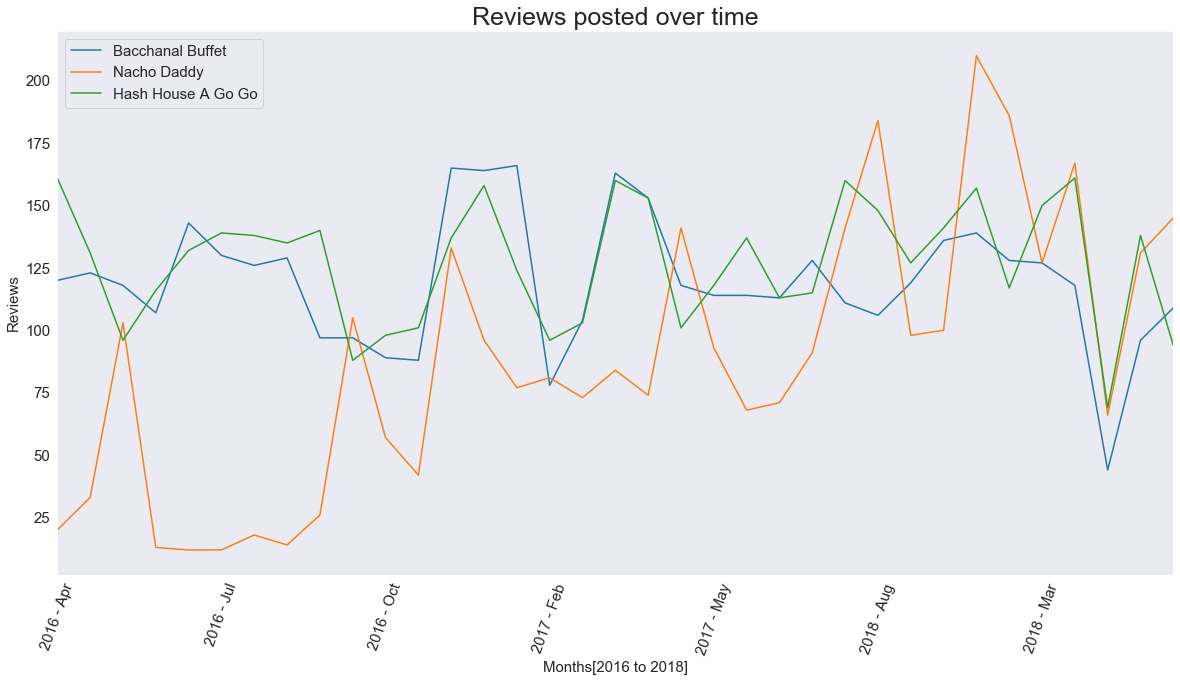

In [46]:
import calendar
def getDateCounts(name):
    temp = top3[top3.name == name]
    temp['month'] = temp['date'].dt.month
    temp['monthAbbr'] = temp['month'].apply(lambda x: calendar.month_abbr[x])
    temp['YearMonth'] = temp['Year'].map(str) +' - '+ temp['monthAbbr']
    size = temp.groupby('YearMonth').size()
    return size

plt.figure(figsize=(20,10))

for i in range(0,3):
    getDateCounts(top3BussList[i]).plot(label=top3BussList[i])

plt.xticks(rotation=70, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Months[2016 to 2018]', fontsize=15)
plt.ylabel('Reviews', fontsize=15)
plt.legend(prop={'size':15})
plt.title('Reviews posted over time', fontsize=25)
plt.show()

### Polarity distribution for 3 restaurants

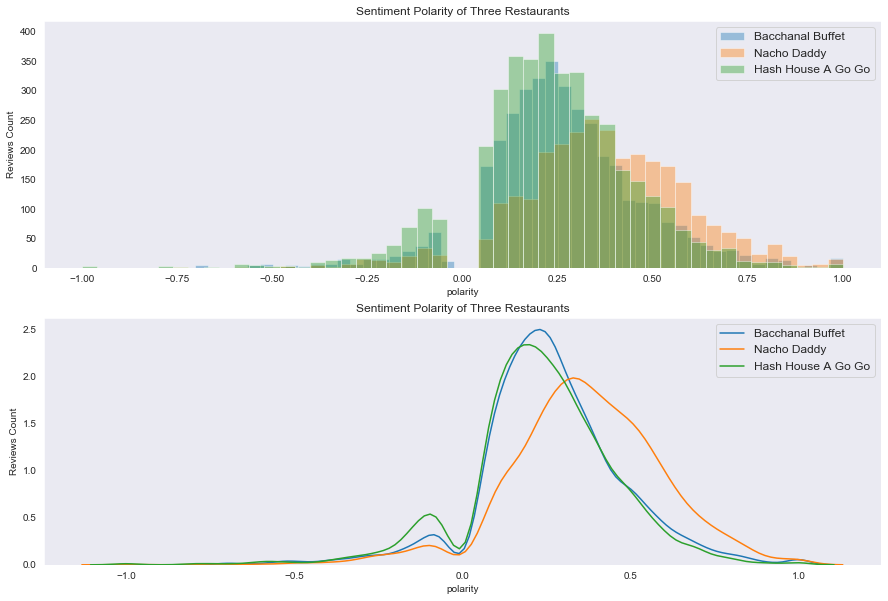

In [47]:
def getDataForPolarityGraph(name):
    temp = top3[top3.name == name]
    data = temp[(temp.polarity >= 0.05) | (temp.polarity <= -0.05)]
    return data["polarity"]

plt.figure(figsize=(15,10))
plt.subplot(211)
for i in range(0,3):
    sns.distplot(getDataForPolarityGraph(top3BussList[i]), kde=False, hist=True, label=top3BussList[i])
plt.legend(prop={"size": 12})
plt.title("Sentiment Polarity of Three Restaurants")
plt.ylabel("Reviews Count")

plt.subplot(212)
for i in range(0,3):
    sns.distplot(getDataForPolarityGraph(top3BussList[i]), kde=True, hist=False, label=top3BussList[i])
plt.legend(prop={"size": 12})
plt.title("Sentiment Polarity of Three Restaurants")
plt.ylabel("Reviews Count")

plt.show()

### Overall sentiments polarity for 3 restaurants

In [48]:
sentiment = []
size = []
negative = []
positive= []
perc_negative = []
perc_positive = []

for i in range(0,3):
    temp = top3[top3.name == top3BussList[i]]
    
    sentiment.append(TextBlob(' '.join(temp['clean_text'].values)).sentiment.polarity)
    size.append(temp.business_id.count())
    negative_c = len(temp[temp.polarity < 0])
    positive_c = len(temp[temp.polarity > 0])
    negative.append(negative_c)
    positive.append(positive_c)
    perc_positive.append(positive_c/(positive_c + negative_c))
    perc_negative.append(negative_c/(positive_c + negative_c))

data = pd.DataFrame({'Restaurants':top3BussList, 'sentiment':sentiment, 'size': size, 'negative': negative,
                     'positive': positive, 'perc_negative': perc_negative, 'perc_positive': perc_positive })
data

,Restaurants,sentiment,size,negative,positive,perc_negative,perc_positive
0,Bacchanal Buffet,0.208910,4180,385,3754,0.093018,0.906982
1,Nacho Daddy,0.299507,3092,204,2866,0.066450,0.933550
2,Hash House A Go Go,0.180671,4452,611,3815,0.138048,0.861952


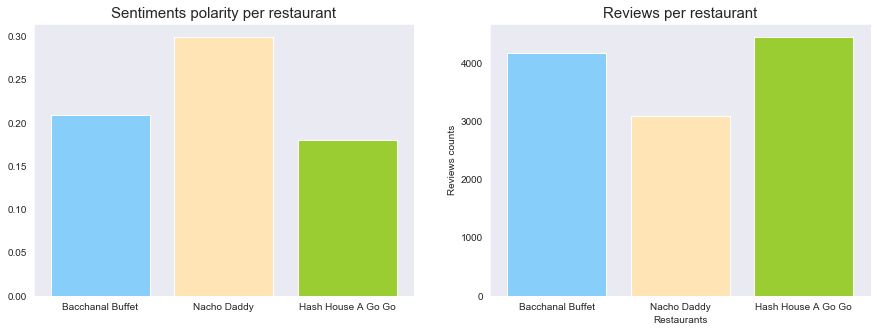

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.bar(data['Restaurants'], data['sentiment'],color=['lightskyblue','moccasin','yellowgreen'])
plt.title('Sentiments polarity per restaurant', fontsize=15)

plt.subplot(122)
plt.bar(data['Restaurants'], data['size'], color=['lightskyblue','moccasin','yellowgreen'])
plt.xlabel('Restaurants')
plt.ylabel('Reviews counts')
plt.title('Reviews per restaurant', fontsize=15)
plt.show()

### Positve VS. Negative reviews percentage for 3 restaurants

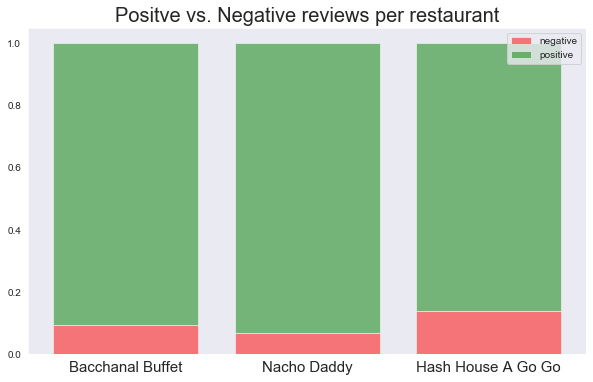

In [50]:
plt.figure(figsize=(10,6))
p1 = plt.bar(data['Restaurants'], data['perc_negative'], color='r',label='negative',alpha=0.5)
p2 = plt.bar(data['Restaurants'], data['perc_positive'], bottom=data['perc_negative'], color='g', label='positive',alpha=0.5)
plt.legend()
plt.xticks(fontsize=15)
plt.title('Positve vs. Negative reviews per restaurant', fontsize=20)
plt.show()

### Frequent words in positive and negative reviews for each restaurant

In [51]:
from collections import Counter
import nltk

def get5CommonWords(text):
    words = nltk.tokenize.word_tokenize(text)
    most_occur = Counter(words).most_common(5)
    word,count = zip(*most_occur)
    return ', '.join(word)

positive_freq_words = []
negative_freq_words = []
for i in range(0,3):
    temp = top3[top3.name == top3BussList[i]]
    positive_freq_words.append(get5CommonWords(' '.join(temp[temp['sentiment']=='pos']['clean_text'].values)))
    negative_freq_words.append(get5CommonWords(' '.join(temp[temp['sentiment']=='neg']['clean_text'].values)))

data = pd.DataFrame({'Restaurants':top3BussList, 
                     'Frequent words in positive reviews':positive_freq_words,
                     'Frequent words in negative reviews': negative_freq_words})
data

,Restaurants,Frequent words in positive reviews,Frequent words in negative reviews
0,Bacchanal Buffet,"buffet, food, good, time, crab","food, buffet, line, crab, time"
1,Nacho Daddy,"nacho, food, great, good, place","food, nacho, service, chicken, place"
2,Hash House A Go Go,"food, chicken, good, portion, place","chicken, food, waffle, service, place"


### Topic Modelling

In [52]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import TfidfModel
import nltk

In [53]:
# Convert to list
def topicKeywords(df):
    tokens = []
    for i, row in df.iterrows():
        text = row["clean_text"]
        words = text.split()
        words = [w for w in words if w.isalpha() and len(w)>2]
        # only screen out NOUN words
        uni_pos = nltk.pos_tag(words, tagset='universal')
        words = [w[0] for w in uni_pos if w[1]=='NOUN']
        tokens.append(words)

    my_dict = Dictionary(tokens)
    my_dict.filter_extremes(no_below=5, no_above=0.85)
   
    # Count Vectorization
    dtm = [my_dict.doc2bow(doc) for doc in tokens]
    
    # TF-IDF Vectorization
    tfidf = TfidfModel(dtm)
    tfidf = tfidf[dtm]

    lda_model = LdaModel(tfidf, num_topics=3, id2word=my_dict, passes=10)
    return lda_model

In [54]:
sentiment = ['pos', 'neg']
for i in range(0,3):
    temp = top3[top3.name == top3BussList[i]]
    for s in sentiment:
        model = topicKeywords(temp[temp['sentiment']==s])
        print(temp.name.values[0], '-', s)
        for i in range(3):
            wp = model.show_topic(i)
            topic_keywords = ", ".join([word for word, prop in wp])
            print('Topic',i+1, ': ', topic_keywords)
        print('----------')

Bacchanal Buffet - pos
Topic 1 :  line, time, buffet, food, price, station, dinner, option, selection, everything
Topic 2 :  crab, leg, selection, quality, buffet, place, rib, vega, everything, seafood
Topic 3 :  line, wait, service, hour, food, time, experience, place, buffet, money
----------
Bacchanal Buffet - neg
Topic 1 :  station, section, staff, table, crab, server, dish, selection, time, meat
Topic 2 :  line, hour, people, wait, time, manager, service, pay, ticket, get
Topic 3 :  buffet, price, quality, crab, food, salty, place, time, vega, everything
----------
Nacho Daddy - pos
Topic 1 :  food, place, time, margarita, service, daddy, location, nacho, server, option
Topic 2 :  place, food, breakfast, margarita, price, filet, nacho, people, service, portion
Topic 3 :  vegan, service, food, place, jovanny, shot, scorpion, jovany, thanks, server
----------
Nacho Daddy - neg
Topic 1 :  chicken, time, burrito, experience, restaurant, plate, price, drink, order, table
Topic 2 :  tac

# Rating prediction

In [55]:
df = pd.read_pickle("./YelpReviewsData.pkl")

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
df.groupby('stars').clean_text.count()

stars
1.0     28128
2.0     15085
3.0     19716
4.0     38004
5.0    107039
Name: clean_text, dtype: int64

In [75]:
# Split data into train and test and create TF-IDF vectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_x, test_x, train_y, test_y = train_test_split(df['clean_text'], df['stars'], test_size=0.3, random_state=42)
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

The text needs to be transformed to vectors so as the algorithms will be able make predictions. We will use the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate how important a word is to a document in a collection of documents

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['clean_text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

### Naive Bayes, Random Forests, Neural Network

#### Model Training Time Comparison

In [77]:
# Naive Bayes Classifier with default parameters
from sklearn.naive_bayes import MultinomialNB
start_time = time.time() 
nbModel = MultinomialNB()
nbModel.fit(xtrain_tfidf, train_y)  
nb_predict_y = nbModel.predict(xtest_tfidf)
nb_accuracy = accuracy_score(test_y, nb_predict_y)
print('Elapsed clock time: ', (time.time() - start_time)/60, ' minutes')

Elapsed clock time:  0.00178296168645223  minutes


In [78]:
# Random Forest (Bagging Model) Classifier
from sklearn.ensemble import RandomForestClassifier
start_time = time.time() 
rfModel = RandomForestClassifier(n_estimators=200, max_depth=4)
rfModel.fit(xtrain_tfidf, train_y)  
rf_predict_y = rfModel.predict(xtest_tfidf)
rf_accuracy = accuracy_score(test_y, rf_predict_y)
print('Elapsed clock time: ', (time.time() - start_time)/60, ' minutes')

Elapsed clock time:  0.2799028158187866  minutes


In [79]:
# Neural Network Classifier

# hidden_layer_sizes : The ith element represents the number of neurons in the ith hidden layer.
# learning_rate : {‘constant’, ‘invscaling’, ‘adaptive’}, default ‘constant’. 
# 'adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing.

from sklearn.neural_network import MLPClassifier
start_time = time.time() 
nnModel = MLPClassifier(alpha = 1, hidden_layer_sizes=(15,7), learning_rate='adaptive')
nnModel.fit(xtrain_tfidf, train_y)  
nn_predict_y = nnModel.predict(xtest_tfidf)
nn_accuracy = accuracy_score(test_y, nn_predict_y)
print('Elapsed clock time: ', (time.time() - start_time)/60, ' minutes')

Elapsed clock time:  3.844096036752065  minutes


#### Model Accuracy Comparision

In [80]:
print('Naive Bayes: {:.3f}'.format(nb_accuracy))
print('Random Forests: {:.3f}'.format(rf_accuracy))
print('Neural Network: {:.3f}'.format(nn_accuracy))

Naive Bayes: 0.647
Random Forests: 0.513
Neural Network: 0.645


Classification accuracy is simply the number of correct predictions divided by all predictions or a ratio of correct predictions to total predictions. From the results, it seems like all the classifiers are performing well. Neural Network has the highest accuracy amongst all the three classifiers.

Now let's plot the confusion matrix for all the three classifiers

#### Confusion Matrix

In [81]:
df['category_id'] = df['stars'].factorize()[0]
category_id_df = df[['stars', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'stars']].values)

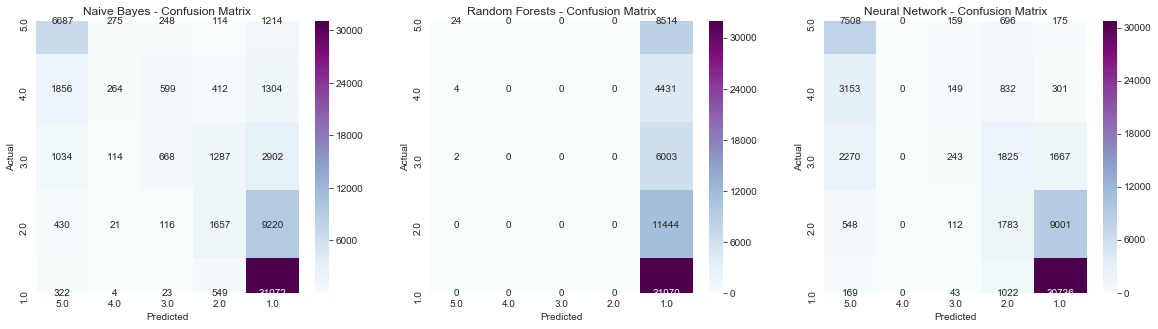

In [82]:
# labels = [1,2,3,4,5]
nb = confusion_matrix(test_y, nbModel.predict(xtest_tfidf))
rf = confusion_matrix(test_y, rfModel.predict(xtest_tfidf))
nn = confusion_matrix(test_y, nnModel.predict(xtest_tfidf))

plt.figure(figsize=(20,5))
plt.subplot(131)
sns.heatmap(nb, annot=True, fmt='d', cmap="BuPu", xticklabels=category_id_df.stars.values, yticklabels=category_id_df.stars.values)
plt.title('Naive Bayes - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.subplot(132)
sns.heatmap(rf, annot=True, fmt='d', cmap="BuPu", xticklabels=category_id_df.stars.values, yticklabels=category_id_df.stars.values)
plt.title('Random Forests - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.subplot(133)
sns.heatmap(nn, annot=True, fmt='d', cmap="BuPu", xticklabels=category_id_df.stars.values, yticklabels=category_id_df.stars.values)
plt.title('Neural Network - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

Number of correct predictions for each class run on the diagonal from top-left to bottom-right.
We can use this to compare how different models are correctly predicting a topic compared to others.

#### Evaluating other metrics using classification report

In [83]:
print('Naive Bayes:')
print(classification_report(test_y, nbModel.predict(xtest_tfidf)))
print('-----------------------------------------------------------------')
print('Random Forests')
print(classification_report(test_y, rfModel.predict(xtest_tfidf)))
print('-----------------------------------------------------------------')
print('Neural Network')
print(classification_report(test_y, nnModel.predict(xtest_tfidf)))

Naive Bayes:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71      8538
           1       0.39      0.06      0.10      4435
           2       0.40      0.11      0.17      6005
           3       0.41      0.14      0.21     11444
           4       0.68      0.97      0.80     31970

    accuracy                           0.65     62392
   macro avg       0.51      0.41      0.40     62392
weighted avg       0.58      0.65      0.57     62392

-----------------------------------------------------------------
Random Forests
              precision    recall  f1-score   support

           0       0.80      0.00      0.01      8538
           1       0.00      0.00      0.00      4435
           2       0.00      0.00      0.00      6005
           3       0.00      0.00      0.00     11444
           4       0.51      1.00      0.68     31970

    accuracy                           0.51     62392
   macro avg       0.26      0.20    

/Users/adarshpatel/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


- Precision is the ability of a classiifer not to label an instance positive that is actually negative. 
- Recall is the ability of a classifier to find all positive instances. Said another way, “for all instances that were actually positive, what percent was classified correctly?”
- The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0.
- Support is the number of actual occurrences of the class in the specified dataset.

From the results, we can observe that random forests provide the best accuracy and recall values, followed by neural network and naive bayes. Even the f1-score is greater than neural network and naive bayes



### Prediction Example

Let's test our classifiers with some new input, lets try it with input text of our dataset(row no = 652). This should belongs to 4 rating category.

In [84]:
# Prediction example
print('Actual Rating:', df.iloc[652]["stars"])
new_text = [df.iloc[652]["text"]]
print('Review: ', new_text[0])
text_features = tfidf_vect.transform(new_text)
nbPredict = nbModel.predict(text_features)
rfPredict = rfModel.predict(text_features)
nnPredict = nnModel.predict(text_features)
print('-------------------------------------------------------')
print('Naive Bayes Prediction: ', rfPredict[0])
print('Random Forest Prediction: ', rfPredict[0])
print('Neural Network Prediction: ', rfPredict[0])

Actual Rating: 4.0
Review:  One of my favorite places in Las Vegas! Their happy hour is fantastic and they have a special menu on Mondays that has amazing deals. The fried chicken sandwich is the best I've ever had. The chicken is so tender and full- and I don't like fried chicken! The drinks are great as well. The ONLY thing is.. they have a very hipster/trendy style (which I love) but the servers sometimes have a "too cool" demeanor. For example, my husband and I came in and sat at the bar on a Sunday afternoon, seemingly after brunch. The bartender was no where to be found for the whole 13 minutes we sat there. However, there was a group of six servers standing right next to the bar, chatting and laughing amongst themselves. Not one of them greeted us or said "someone will be right with you"- not one word. The busboy was busting his butt around the bar so I cut him some slack, but still, you do know how to say hi, right? We left without ever being spoken to. We've been back and will

As we can observe from the results all the classifiers predict the rating category correctly. The performance of all the three classifiers was good but Neural Network slighlty outperformed others. The precision, recall and f-score for all the categories is much better in Neural Network classification. It is more accurate.